In [1]:
import numpy as np
import torch
import torch.nn
import torch.optim
from abc import abstractmethod
from collections import defaultdict
from functools import lru_cache
from itertools import count
from typing import List, Dict
from typing import Tuple, Any
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from torch.nn import MSELoss, ReLU, L1Loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from importlib import reload
from config import Config
import config
from data import MDataset, Graph, load_graphs, save_dataset_pkl, load_dataset_pkl, save_scalers_pkl, load_scalers_pkl
import data
from base_module import MModule, nested_detach
import base_module
from executor import single_train_loop, grid_search_loop
import executor
from objects import ModelType
import objects
from metric import MetricUtil
import metric
from logger import init_logging
import logger
reload(config)
reload(data)
reload(base_module)
reload(executor)
reload(objects)
reload(metric)
reload(logger)
from config import Config
from data import MDataset, Graph, load_graphs
from base_module import MModule
from objects import ModelType
from metric import MetricUtil
from logger import init_logging
init_logging()

datasets_path: /root/guohao/repos/DLT-perf-model/datasets
configs_path: /root/guohao/repos/DLT-perf-model/notebooks/configs
datasets_path: /root/guohao/repos/DLT-perf-model/datasets
configs_path: /root/guohao/repos/DLT-perf-model/notebooks/configs


In [3]:
dataset_environment_str = "T4_CPUALL"
normalizer_cls = StandardScaler # MinMaxScaler
dummy = False

In [4]:
train_configs = {
    ModelType.MLP.name: Config.from_dict({
        "model": "MLP",
        "all_seed": 42,
        "dataset_environment_str": dataset_environment_str,
        "dataset_normalization": "Standard",
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_dummy": False,
        "batch_size": 32,
        "eval_steps": 5000,
        "learning_rate": 1e-5,
        "epochs": 5,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.PerfNet.name: Config.from_dict({
        "model": "PerfNet",
        "dataset_environment_str": dataset_environment_str,
        "dataset_normalization": "Standard",
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_dummy": True,
        "batch_size": 32,
        "eval_steps": 5000,
        "learning_rate": 1e-5,
        "epochs": 10,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    })
}

model_type = ModelType.MLP
conf = train_configs[model_type.name]

In [5]:
eval_graphs = load_graphs(dataset_environment_str,
                            train_or_eval="train",
                            use_dummy=dummy,
                            max_row=10)
train_graphs = load_graphs(dataset_environment_str,
                            train_or_eval="train",
                            use_dummy=dummy,
                            max_row=100)

[2023-12-12 17:28:56,895] {data.py:441} INFO - Loading graphs train
[2023-12-12 17:28:56,895] {data.py:412} INFO - Loading merged.csv
[2023-12-12 17:28:57,394] {data.py:415} INFO - Loaded merged.csv, 200000 rows
[2023-12-12 17:28:57,764] {data.py:421} INFO - Loaded mnasnet1_3.180_7.csv, 769 rows
[2023-12-12 17:28:58,491] {data.py:421} INFO - Loaded convnext_small.96_7.csv, 1595 rows
[2023-12-12 17:28:58,912] {data.py:421} INFO - Loaded googlenet.120_7.csv, 905 rows
[2023-12-12 17:28:59,247] {data.py:421} INFO - Loaded mobilenet_v3_small.249_7.csv, 732 rows
[2023-12-12 17:28:59,387] {data.py:421} INFO - Loaded squeezenet1_0.173_7.csv, 280 rows
[2023-12-12 17:28:59,724] {data.py:421} INFO - Loaded rand_4000.251_7.csv, 719 rows
[2023-12-12 17:29:00,869] {data.py:421} INFO - Loaded densenet161.132_7.csv, 2507 rows
[2023-12-12 17:29:02,037] {data.py:421} INFO - Loaded densenet169.127_7.csv, 2633 rows
[2023-12-12 17:29:02,196] {data.py:421} INFO - Loaded vgg19_bn.119_7.csv, 333 rows
[2023-12

In [6]:
len(eval_graphs), len(train_graphs)

(162, 819)

In [7]:

def init_dataset(graphs: List[Graph]) -> MDataset:
    op_X, op_Y = list(), list()
    data_idx_to_graph = dict()
    counter = iter(count())
    op_feature_len = 0

    def node_features(g: Graph) -> Tuple[
        List[Dict], List[Dict]]:
        X, Y = list(), list()
        for i, node in enumerate(g.nodes):
            x_op_feature = node.op.to_feature_array("complex")
            x = {
                "x_op_feature": x_op_feature
            }
            node_durations = (node.duration,node.gap)
            x["x_id"] = i
            x["x_graph_id"] = g.ID
            y = {"y_node_durations": node_durations, "y_id": i, "y_graph_id": g.ID}
            X.append(x)
            Y.append(y)
        return X, Y

    for graph in graphs:
        X, Y = node_features(graph)
        for x in X:
            # if len(x['x_op_feature'])!=37:
            #     print(x['x_graph_id'], len(x['x_op_feature']))
            op_feature_len = max(op_feature_len, len(x["x_op_feature"]))
        op_X.extend(X)
        op_Y.extend(Y)
        for i in range(len(X)):
            data_idx_to_graph[next(counter)] = graph
    for x in op_X:
        v = x["x_op_feature"]
        x["x_op_feature"] = np.pad(v, (0, op_feature_len - v.size))

    dataset = MDataset(op_X, op_Y)
    return dataset

train_ds = init_dataset(train_graphs)
eval_ds = init_dataset(eval_graphs)

In [8]:
def get_scalers(ds):
    scaler_cls = normalizer_cls
    op_feature_array = list()
    y_array = list()

    for data in ds:
        feature, label = data
        op_feature_array.append(feature["x_op_feature"])
        y_array.append(label["y_node_durations"])

    op_feature_array = np.array(op_feature_array)
    y_array = np.array(y_array)

    op_feature_scaler = scaler_cls()
    op_feature_scaler.fit(op_feature_array)

    y_scaler = scaler_cls()
    y_scaler.fit(y_array)
    return op_feature_scaler, y_scaler

scalers = get_scalers(train_ds)
op_feature_scaler, y_scaler = scalers

In [9]:

def preprocess_dataset(ds: MDataset) -> MDataset:
    op_feature_array = list()
    y_array = list()

    for data in ds:
        feature, label = data
        op_feature_array.append(feature["x_op_feature"])
        y_array.append(label["y_node_durations"])

    op_feature_array = np.array(op_feature_array, dtype=np.float32)
    y_array = np.array(y_array, dtype=np.float32)


    op_feature_array = op_feature_scaler.transform(op_feature_array)
    y_array = y_scaler.transform(y_array)

    processed_features = list()
    processed_labels = list()
    for i, data in enumerate(ds):
        feature, label = data
        processed_features.append({
            "x_id": feature["x_id"],
            "x_graph_id": feature["x_graph_id"],
            # 运行时再传到cuda那边
            # "x_op_feature": torch.Tensor(op_feature_array[i]).to(device=self.conf.device)
            "x_op_feature": torch.Tensor(op_feature_array[i])
        })
        processed_labels.append({
            "y_id": label["y_id"],
            "y_graph_id": label["y_graph_id"],
            # "y_node_durations": torch.Tensor(y_array[i]).to(device=self.conf.device)
            "y_node_durations": torch.Tensor(y_array[i])
        })

    ds = MDataset(processed_features, processed_labels)
    return ds

preprocessed_train_ds = preprocess_dataset(train_ds)
preprocessed_eval_ds = preprocess_dataset(eval_ds)

In [10]:
save_dataset_pkl(preprocessed_train_ds, conf.dataset_environment, "OpBased", 'train',
                         conf.dataset_normalization)
save_dataset_pkl(preprocessed_eval_ds, conf.dataset_environment, "OpBased", 'eval',
                         conf.dataset_normalization)
save_scalers_pkl(scalers, conf.dataset_environment, "OpBased", 'train',
                         conf.dataset_normalization)

In [11]:
preprocessed_train_ds = load_dataset_pkl(conf.dataset_environment, "OpBased", 'train', 
                                         conf.dataset_normalization)
preprocessed_eval_ds = load_dataset_pkl(conf.dataset_environment, "OpBased", 'eval',
                                        conf.dataset_normalization)
scalers = load_scalers_pkl(conf.dataset_environment, "OpBased", 'train',
                           conf.dataset_normalization)


Loading dataset T4_CPU-1 OpBased train Standard
Loading dataset T4_CPU-1 OpBased eval Standard
Loading scalers T4_CPU-1 OpBased train, Standard


In [12]:
op_feature_scaler, y_scaler = scalers

In [13]:
def compute_evaluate_metrics(input_batches, output_batches, eval_loss) -> Dict[str, float]:
    batches_len = len(input_batches)

    def compute_op_durations(_logits):
        transformed: np.ndarray = y_scaler.inverse_transform(_logits)
        durations = transformed.sum(axis=1)
        return durations

    graph_id_to_duration_pred = defaultdict(int)
    for idx in range(batches_len):
        inputs = input_batches[idx]
        logits = output_batches[idx]
        logits = nested_detach(logits)
        logits = logits.cpu().numpy()
        graph_ids = inputs["x_graph_id"]
        op_durations = compute_op_durations(logits)
        for i, graph_id in enumerate(graph_ids):
            op_duration = op_durations[i].item()
            graph_id_to_duration_pred[graph_id] += op_duration
    duration_metrics = MetricUtil.compute_duration_metrics(eval_graphs, graph_id_to_duration_pred)
    return {"eval_loss": eval_loss, **duration_metrics}


In [14]:

def to_device(conf, features, labels):
    features['x_op_feature'] = features["x_op_feature"].to(device=conf.device)
    labels['y_node_durations'] = labels['y_node_durations'].to(device=conf.device)
    return features, labels

In [15]:
class MLPModel(MModule):

    @staticmethod
    def dimension_len(t):
        return t[-1] - t[0]
    
    @staticmethod
    def grid_search_model_params() -> Dict[str, List[Any]]:
        return {
            "learning_rate": [1e-3, 1e-4, 1e-5],
            'batch_size': [16, 32, 64],
            'epochs': [5, 10, 20, 30],
            'optimizer': ['Adam', 'SGD'],
        }

    def __init__(self, input_dimension, output_dimension, **kwargs):
        super().__init__(**kwargs)
        self.input = torch.nn.Linear(input_dimension, 256)
        self.relu1 = ReLU()
        self.dense1 = torch.nn.Linear(256, 128)
        self.relu2 = ReLU()
        self.dense2 = torch.nn.Linear(128, 64)
        self.relu3 = ReLU()
        self.output = torch.nn.Linear(64, output_dimension)
        self.loss_fn = L1Loss()

    def forward(self, X):
        X = X["x_op_feature"]
        X = self.input(X)
        X = self.relu1(X)
        X = self.dense1(X)
        X = self.relu2(X)
        X = self.dense2(X)
        X = self.relu3(X)
        Y = self.output(X)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_node_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss


def init_MLP_model() -> MModule | Any:
    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    return MLPModel(input_dimension=len(sample_x_dict["x_op_feature"]),
                    output_dimension=len(sample_y_dict["y_node_durations"]))

In [16]:

class PerfNetModel(MModule):
    @staticmethod
    def dimension_len(t):
        return t[-1] - t[0]
    
    @staticmethod
    def grid_search_model_params() -> Dict[str, List[Any]]:
        return {
            "learning_rate": [1e-3, 1e-4, 1e-5],
            'batch_size': [16, 32, 64],
            'epochs': [5, 10, 20, 30],
            'optimizer': ['Adam', 'SGD'],
        }

    def __init__(self, output_dimension, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = torch.nn.LazyConv1d(out_channels=32, kernel_size=3, bias=True, padding_mode='zeros')
        self.conv2 = torch.nn.LazyConv1d(out_channels=128, kernel_size=2, bias=True, padding_mode='zeros')
        self.flatten = torch.nn.Flatten()
        self.dense1 = torch.nn.LazyLinear(32)
        self.relu1 = ReLU()
        self.dense2 = torch.nn.LazyLinear(64)
        self.relu2 = ReLU()
        self.dense3 = torch.nn.LazyLinear(128)
        self.relu3 = ReLU()
        self.dense4 = torch.nn.LazyLinear(256)
        self.relu4 = ReLU()
        self.dropout = torch.nn.Dropout(p=0.3)
        self.output = torch.nn.LazyLinear(output_dimension)
        self.loss_fn = L1Loss()

    def forward(self, X):
        X = X["x_op_feature"]
        X = torch.unsqueeze(X, dim=1)
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.flatten(X)
        X = self.dense1(X)
        X = self.relu1(X)
        X = self.dense2(X)
        X = self.relu2(X)
        X = self.dense3(X)
        X = self.relu3(X)
        X = self.dense4(X)
        X = self.relu4(X)
        X = self.dropout(X)
        Y = self.output(X)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_node_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss


def init_PerfNet_model() -> MModule | Any:
    sample_y_dict = preprocessed_train_ds.labels[0]
    return PerfNetModel(output_dimension=len(sample_y_dict["y_node_durations"]))



In [17]:
init_model_funcs = {
    ModelType.MLP.name: init_MLP_model,
    ModelType.PerfNet.name: init_PerfNet_model,
}


init_model = init_model_funcs[model_type.name]

model = init_model()
model = model.to(conf.device)


[2023-12-12 17:44:49,415] {executor.py:120} INFO - ModelType.MLP start single training.
[2023-12-12 17:44:49,416] {executor.py:122} INFO - ModelType.MLP training epoch 0


  0%|          | 0/31250 [00:00<?, ?it/s]

[2023-12-12 17:44:50,187] {executor.py:139} INFO - ModelType.MLP trained for 0.772837182 seconds.
[2023-12-12 17:44:50,188] {executor.py:140} INFO - ModelType.MLP eval at step 0.
[2023-12-12 17:44:54,046] {executor.py:144} INFO - ModelType.MLP train loss: 0.334624320268631, eval metrics: {'eval_loss': 0.2563581539452076, 'MRE': 3.6022948001723334, 'MAE': 1.9513841827668168, 'RMSE': 1356.2769075599733}
[2023-12-12 17:44:54,047] {executor.py:174} INFO - Saving model at step 0 with loss 0.334624320268631,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 16%|█▌        | 4998/31250 [00:15<00:56, 462.94it/s]

[2023-12-12 17:45:05,290] {executor.py:139} INFO - ModelType.MLP trained for 15.875611435 seconds.
[2023-12-12 17:45:05,291] {executor.py:140} INFO - ModelType.MLP eval at step 5000.
[2023-12-12 17:45:09,234] {executor.py:144} INFO - ModelType.MLP train loss: 0.08142563700675964, eval metrics: {'eval_loss': 0.11048335065826774, 'MRE': 0.29265013946421103, 'MAE': 0.5092518771624857, 'RMSE': 720.7391705221888}
[2023-12-12 17:45:09,235] {executor.py:174} INFO - Saving model at step 5000 with loss 0.08142563700675964,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 32%|███▏      | 9965/31250 [00:30<00:45, 463.45it/s]

[2023-12-12 17:45:20,022] {executor.py:139} INFO - ModelType.MLP trained for 30.607674938 seconds.
[2023-12-12 17:45:20,023] {executor.py:140} INFO - ModelType.MLP eval at step 10000.
[2023-12-12 17:45:23,945] {executor.py:144} INFO - ModelType.MLP train loss: 0.048256147652864456, eval metrics: {'eval_loss': 0.10196420677350834, 'MRE': 0.2669740204219562, 'MAE': 0.48340914796396967, 'RMSE': 712.5873952924399}
[2023-12-12 17:45:23,945] {executor.py:174} INFO - Saving model at step 10000 with loss 0.048256147652864456,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 48%|████▊     | 14956/31250 [00:44<00:32, 502.93it/s]

[2023-12-12 17:45:34,128] {executor.py:139} INFO - ModelType.MLP trained for 44.712937357 seconds.
[2023-12-12 17:45:34,128] {executor.py:140} INFO - ModelType.MLP eval at step 15000.
[2023-12-12 17:45:38,036] {executor.py:144} INFO - ModelType.MLP train loss: 0.22329658269882202, eval metrics: {'eval_loss': 0.09870636867498979, 'MRE': 0.22813722062204422, 'MAE': 0.44493151454860197, 'RMSE': 700.9413957164234}
[2023-12-12 17:45:38,037] {executor.py:174} INFO - Saving model at step 15000 with loss 0.22329658269882202,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 64%|██████▍   | 19956/31250 [00:58<00:23, 488.40it/s]

[2023-12-12 17:45:48,028] {executor.py:139} INFO - ModelType.MLP trained for 58.612807512 seconds.
[2023-12-12 17:45:48,028] {executor.py:140} INFO - ModelType.MLP eval at step 20000.
[2023-12-12 17:45:52,069] {executor.py:144} INFO - ModelType.MLP train loss: 0.061843156814575195, eval metrics: {'eval_loss': 0.09670744694985449, 'MRE': 0.23701349270417432, 'MAE': 0.4447898706031729, 'RMSE': 699.0252117293774}
[2023-12-12 17:45:52,070] {executor.py:174} INFO - Saving model at step 20000 with loss 0.061843156814575195,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 80%|███████▉  | 24988/31250 [01:12<00:12, 481.86it/s]

[2023-12-12 17:46:02,386] {executor.py:139} INFO - ModelType.MLP trained for 72.971091719 seconds.
[2023-12-12 17:46:02,386] {executor.py:140} INFO - ModelType.MLP eval at step 25000.
[2023-12-12 17:46:06,371] {executor.py:144} INFO - ModelType.MLP train loss: 0.07051758468151093, eval metrics: {'eval_loss': 0.09514268841695041, 'MRE': 0.22767698846553594, 'MAE': 0.43575259728686666, 'RMSE': 696.523488908339}
[2023-12-12 17:46:06,372] {executor.py:174} INFO - Saving model at step 25000 with loss 0.07051758468151093,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 96%|█████████▌| 29957/31250 [01:26<00:02, 502.42it/s]

[2023-12-12 17:46:16,408] {executor.py:139} INFO - ModelType.MLP trained for 86.992832126 seconds.
[2023-12-12 17:46:16,408] {executor.py:140} INFO - ModelType.MLP eval at step 30000.
[2023-12-12 17:46:20,366] {executor.py:144} INFO - ModelType.MLP train loss: 0.045850738883018494, eval metrics: {'eval_loss': 0.09382090955504216, 'MRE': 0.2240169709035322, 'MAE': 0.4285247649774384, 'RMSE': 693.5656076687976}
[2023-12-12 17:46:20,366] {executor.py:174} INFO - Saving model at step 30000 with loss 0.045850738883018494,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


100%|██████████| 31250/31250 [01:33<00:00, 333.86it/s]

[2023-12-12 17:46:23,021] {executor.py:122} INFO - ModelType.MLP training epoch 1



 12%|█▏        | 3715/31250 [00:07<00:56, 491.16it/s]

[2023-12-12 17:46:30,816] {executor.py:139} INFO - ModelType.MLP trained for 101.401128829 seconds.
[2023-12-12 17:46:30,816] {executor.py:140} INFO - ModelType.MLP eval at step 35000.
[2023-12-12 17:46:34,776] {executor.py:144} INFO - ModelType.MLP train loss: 0.08183603733778, eval metrics: {'eval_loss': 0.0926185130655393, 'MRE': 0.21834318148401732, 'MAE': 0.4226348474713622, 'RMSE': 691.356259028942}
[2023-12-12 17:46:34,777] {executor.py:174} INFO - Saving model at step 35000 with loss 0.08183603733778,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 28%|██▊       | 8750/31250 [00:21<00:44, 501.14it/s]

[2023-12-12 17:46:45,011] {executor.py:139} INFO - ModelType.MLP trained for 115.5959859 seconds.
[2023-12-12 17:46:45,011] {executor.py:140} INFO - ModelType.MLP eval at step 40000.
[2023-12-12 17:46:48,909] {executor.py:144} INFO - ModelType.MLP train loss: 0.029497822746634483, eval metrics: {'eval_loss': 0.09155551991390996, 'MRE': 0.22448124670294645, 'MAE': 0.4255352231331952, 'RMSE': 691.2498524456689}
[2023-12-12 17:46:48,910] {executor.py:174} INFO - Saving model at step 40000 with loss 0.029497822746634483,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 44%|████▍     | 13740/31250 [00:35<00:34, 509.59it/s]

[2023-12-12 17:46:58,830] {executor.py:139} INFO - ModelType.MLP trained for 129.415334947 seconds.
[2023-12-12 17:46:58,831] {executor.py:140} INFO - ModelType.MLP eval at step 45000.
[2023-12-12 17:47:02,787] {executor.py:144} INFO - ModelType.MLP train loss: 0.05914808437228203, eval metrics: {'eval_loss': 0.09056062125620432, 'MRE': 0.20052178082137234, 'MAE': 0.40674025147627124, 'RMSE': 686.5400539603281}
[2023-12-12 17:47:02,788] {executor.py:174} INFO - Saving model at step 45000 with loss 0.05914808437228203,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 60%|█████▉    | 18714/31250 [00:49<00:25, 485.50it/s]

[2023-12-12 17:47:12,958] {executor.py:139} INFO - ModelType.MLP trained for 143.543589491 seconds.
[2023-12-12 17:47:12,959] {executor.py:140} INFO - ModelType.MLP eval at step 50000.
[2023-12-12 17:47:16,840] {executor.py:144} INFO - ModelType.MLP train loss: 0.0876898393034935, eval metrics: {'eval_loss': 0.08985159780415707, 'MRE': 0.2009409601820538, 'MAE': 0.40429108843375006, 'RMSE': 683.8818177190003}
[2023-12-12 17:47:16,841] {executor.py:174} INFO - Saving model at step 50000 with loss 0.0876898393034935,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 76%|███████▌  | 23725/31250 [01:04<00:15, 487.69it/s]

[2023-12-12 17:47:27,171] {executor.py:139} INFO - ModelType.MLP trained for 157.756140226 seconds.
[2023-12-12 17:47:27,171] {executor.py:140} INFO - ModelType.MLP eval at step 55000.
[2023-12-12 17:47:31,051] {executor.py:144} INFO - ModelType.MLP train loss: 0.3348067104816437, eval metrics: {'eval_loss': 0.08875311230976135, 'MRE': 0.1936238170849721, 'MAE': 0.39896502332085865, 'RMSE': 682.7851877546717}
[2023-12-12 17:47:31,051] {executor.py:174} INFO - Saving model at step 55000 with loss 0.3348067104816437,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 92%|█████████▏| 28744/31250 [01:18<00:05, 484.30it/s]

[2023-12-12 17:47:41,261] {executor.py:139} INFO - ModelType.MLP trained for 171.846330919 seconds.
[2023-12-12 17:47:41,262] {executor.py:140} INFO - ModelType.MLP eval at step 60000.
[2023-12-12 17:47:45,343] {executor.py:144} INFO - ModelType.MLP train loss: 0.0731838047504425, eval metrics: {'eval_loss': 0.08805097709720955, 'MRE': 0.2092451009924243, 'MAE': 0.4111310922932326, 'RMSE': 685.4225026359237}
[2023-12-12 17:47:45,344] {executor.py:174} INFO - Saving model at step 60000 with loss 0.0731838047504425,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


100%|██████████| 31250/31250 [01:27<00:00, 355.28it/s]

[2023-12-12 17:47:50,982] {executor.py:122} INFO - ModelType.MLP training epoch 2



  8%|▊         | 2466/31250 [00:04<00:57, 504.69it/s]

[2023-12-12 17:47:56,036] {executor.py:139} INFO - ModelType.MLP trained for 186.621290709 seconds.
[2023-12-12 17:47:56,036] {executor.py:140} INFO - ModelType.MLP eval at step 65000.
[2023-12-12 17:47:59,884] {executor.py:144} INFO - ModelType.MLP train loss: 0.05090852081775665, eval metrics: {'eval_loss': 0.08744299915885553, 'MRE': 0.18377362783208645, 'MAE': 0.38934544530483817, 'RMSE': 678.4413554905472}
[2023-12-12 17:47:59,884] {executor.py:174} INFO - Saving model at step 65000 with loss 0.05090852081775665,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 24%|██▍       | 7466/31250 [00:18<00:45, 521.09it/s]

[2023-12-12 17:48:09,811] {executor.py:139} INFO - ModelType.MLP trained for 200.396318873 seconds.
[2023-12-12 17:48:09,812] {executor.py:140} INFO - ModelType.MLP eval at step 70000.
[2023-12-12 17:48:13,634] {executor.py:144} INFO - ModelType.MLP train loss: 0.06183236092329025, eval metrics: {'eval_loss': 0.08668289173142053, 'MRE': 0.1886335811354295, 'MAE': 0.39125982542996146, 'RMSE': 677.7269733757744}
[2023-12-12 17:48:13,634] {executor.py:174} INFO - Saving model at step 70000 with loss 0.06183236092329025,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 40%|███▉      | 12491/31250 [00:32<00:36, 520.58it/s]

[2023-12-12 17:48:23,233] {executor.py:139} INFO - ModelType.MLP trained for 213.81811593 seconds.
[2023-12-12 17:48:23,233] {executor.py:140} INFO - ModelType.MLP eval at step 75000.
[2023-12-12 17:48:27,192] {executor.py:144} INFO - ModelType.MLP train loss: 0.0804356262087822, eval metrics: {'eval_loss': 0.08597876954820938, 'MRE': 0.19007385455600817, 'MAE': 0.39140312988446546, 'RMSE': 677.4615998250025}
[2023-12-12 17:48:27,193] {executor.py:174} INFO - Saving model at step 75000 with loss 0.0804356262087822,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 56%|█████▌    | 17470/31250 [00:49<00:36, 382.31it/s]

[2023-12-12 17:48:40,261] {executor.py:139} INFO - ModelType.MLP trained for 230.846380905 seconds.
[2023-12-12 17:48:40,262] {executor.py:140} INFO - ModelType.MLP eval at step 80000.
[2023-12-12 17:48:45,096] {executor.py:144} INFO - ModelType.MLP train loss: 0.05765917897224426, eval metrics: {'eval_loss': 0.08521854181818664, 'MRE': 0.19316900572499418, 'MAE': 0.39732410118512673, 'RMSE': 679.5139263174118}
[2023-12-12 17:48:45,097] {executor.py:174} INFO - Saving model at step 80000 with loss 0.05765917897224426,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 72%|███████▏  | 22465/31250 [01:06<00:19, 451.92it/s]

[2023-12-12 17:48:58,051] {executor.py:139} INFO - ModelType.MLP trained for 248.636394125 seconds.
[2023-12-12 17:48:58,052] {executor.py:140} INFO - ModelType.MLP eval at step 85000.
[2023-12-12 17:49:02,047] {executor.py:144} INFO - ModelType.MLP train loss: 0.06831169128417969, eval metrics: {'eval_loss': 0.08477858036747202, 'MRE': 0.1882519478189171, 'MAE': 0.3876534380722777, 'RMSE': 675.8025826278068}
[2023-12-12 17:49:02,049] {executor.py:174} INFO - Saving model at step 85000 with loss 0.06831169128417969,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 88%|████████▊ | 27489/31250 [01:22<00:07, 476.75it/s]

[2023-12-12 17:49:13,024] {executor.py:139} INFO - ModelType.MLP trained for 263.609464319 seconds.
[2023-12-12 17:49:13,025] {executor.py:140} INFO - ModelType.MLP eval at step 90000.
[2023-12-12 17:49:17,145] {executor.py:144} INFO - ModelType.MLP train loss: 0.050973080098629, eval metrics: {'eval_loss': 0.08418458105458879, 'MRE': 0.18735399268445432, 'MAE': 0.38802116990234164, 'RMSE': 674.8362029039657}
[2023-12-12 17:49:17,146] {executor.py:174} INFO - Saving model at step 90000 with loss 0.050973080098629,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


100%|██████████| 31250/31250 [01:34<00:00, 332.33it/s]

[2023-12-12 17:49:25,018] {executor.py:122} INFO - ModelType.MLP training epoch 3



  4%|▍         | 1242/31250 [00:02<01:01, 487.27it/s]

[2023-12-12 17:49:27,670] {executor.py:139} INFO - ModelType.MLP trained for 278.255326602 seconds.
[2023-12-12 17:49:27,670] {executor.py:140} INFO - ModelType.MLP eval at step 95000.
[2023-12-12 17:49:31,695] {executor.py:144} INFO - ModelType.MLP train loss: 0.0896180272102356, eval metrics: {'eval_loss': 0.08363381851296872, 'MRE': 0.18557454368150136, 'MAE': 0.3871416510473948, 'RMSE': 674.2412341663633}
[2023-12-12 17:49:31,696] {executor.py:174} INFO - Saving model at step 95000 with loss 0.0896180272102356,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 20%|█▉        | 6226/31250 [00:16<00:50, 500.10it/s]

[2023-12-12 17:49:41,794] {executor.py:139} INFO - ModelType.MLP trained for 292.379320819 seconds.
[2023-12-12 17:49:41,795] {executor.py:140} INFO - ModelType.MLP eval at step 100000.
[2023-12-12 17:49:45,808] {executor.py:144} INFO - ModelType.MLP train loss: 0.050999704748392105, eval metrics: {'eval_loss': 0.08317043039084412, 'MRE': 0.18505834249564218, 'MAE': 0.3859871201741529, 'RMSE': 673.2230704450778}
[2023-12-12 17:49:45,809] {executor.py:174} INFO - Saving model at step 100000 with loss 0.050999704748392105,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 36%|███▌      | 11230/31250 [00:31<00:40, 495.97it/s]

[2023-12-12 17:49:56,081] {executor.py:139} INFO - ModelType.MLP trained for 306.666517968 seconds.
[2023-12-12 17:49:56,082] {executor.py:140} INFO - ModelType.MLP eval at step 105000.
[2023-12-12 17:50:00,006] {executor.py:144} INFO - ModelType.MLP train loss: 0.0864199623465538, eval metrics: {'eval_loss': 0.08274030230343342, 'MRE': 0.16412624219392194, 'MAE': 0.36866960519982306, 'RMSE': 668.6490356588845}
[2023-12-12 17:50:00,007] {executor.py:174} INFO - Saving model at step 105000 with loss 0.0864199623465538,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 52%|█████▏    | 16207/31250 [00:45<00:29, 502.67it/s]

[2023-12-12 17:50:10,474] {executor.py:139} INFO - ModelType.MLP trained for 321.059827321 seconds.
[2023-12-12 17:50:10,475] {executor.py:140} INFO - ModelType.MLP eval at step 110000.
[2023-12-12 17:50:14,424] {executor.py:144} INFO - ModelType.MLP train loss: 0.06062878295779228, eval metrics: {'eval_loss': 0.0823693460024055, 'MRE': 0.18210436407868186, 'MAE': 0.3822729480609204, 'RMSE': 671.7073450224108}
[2023-12-12 17:50:14,425] {executor.py:174} INFO - Saving model at step 110000 with loss 0.06062878295779228,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 68%|██████▊   | 21222/31250 [00:59<00:19, 526.73it/s]

[2023-12-12 17:50:24,282] {executor.py:139} INFO - ModelType.MLP trained for 334.867649775 seconds.
[2023-12-12 17:50:24,283] {executor.py:140} INFO - ModelType.MLP eval at step 115000.
[2023-12-12 17:50:28,159] {executor.py:144} INFO - ModelType.MLP train loss: 0.056818876415491104, eval metrics: {'eval_loss': 0.08234890261756256, 'MRE': 0.17758198473174377, 'MAE': 0.377704144077254, 'RMSE': 668.7968929909492}
[2023-12-12 17:50:28,160] {executor.py:174} INFO - Saving model at step 115000 with loss 0.056818876415491104,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 84%|████████▍ | 26225/31250 [01:13<00:11, 426.03it/s]

[2023-12-12 17:50:38,218] {executor.py:139} INFO - ModelType.MLP trained for 348.803362645 seconds.
[2023-12-12 17:50:38,219] {executor.py:140} INFO - ModelType.MLP eval at step 120000.
[2023-12-12 17:50:42,723] {executor.py:144} INFO - ModelType.MLP train loss: 0.09768978506326675, eval metrics: {'eval_loss': 0.08206970947612077, 'MRE': 0.17397655344030843, 'MAE': 0.3768519940476543, 'RMSE': 668.865358031997}
[2023-12-12 17:50:42,723] {executor.py:174} INFO - Saving model at step 120000 with loss 0.09768978506326675,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


100%|██████████| 31250/31250 [01:29<00:00, 349.97it/s]

[2023-12-12 17:50:54,314] {executor.py:122} INFO - ModelType.MLP training epoch 4



  0%|          | 0/31250 [00:00<?, ?it/s]

[2023-12-12 17:50:54,393] {executor.py:139} INFO - ModelType.MLP trained for 364.977901618 seconds.
[2023-12-12 17:50:54,393] {executor.py:140} INFO - ModelType.MLP eval at step 125000.
[2023-12-12 17:50:59,067] {executor.py:144} INFO - ModelType.MLP train loss: 2.531705617904663, eval metrics: {'eval_loss': 0.08133934128931723, 'MRE': 0.17131780383968095, 'MAE': 0.3706306724632669, 'RMSE': 666.5263888750587}
[2023-12-12 17:50:59,069] {executor.py:174} INFO - Saving model at step 125000 with loss 2.531705617904663,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 16%|█▌        | 4991/31250 [00:16<00:58, 451.04it/s]

[2023-12-12 17:51:10,379] {executor.py:139} INFO - ModelType.MLP trained for 380.9644781 seconds.
[2023-12-12 17:51:10,380] {executor.py:140} INFO - ModelType.MLP eval at step 130000.
[2023-12-12 17:51:14,657] {executor.py:144} INFO - ModelType.MLP train loss: 0.04033210501074791, eval metrics: {'eval_loss': 0.08123080873811618, 'MRE': 0.1793184271105952, 'MAE': 0.3767186520719219, 'RMSE': 667.5431803407298}
[2023-12-12 17:51:14,658] {executor.py:174} INFO - Saving model at step 130000 with loss 0.04033210501074791,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 32%|███▏      | 9995/31250 [00:31<00:45, 468.17it/s]

[2023-12-12 17:51:26,020] {executor.py:139} INFO - ModelType.MLP trained for 396.605771212 seconds.
[2023-12-12 17:51:26,021] {executor.py:140} INFO - ModelType.MLP eval at step 135000.
[2023-12-12 17:51:29,983] {executor.py:144} INFO - ModelType.MLP train loss: 0.07530216872692108, eval metrics: {'eval_loss': 0.08100846451614983, 'MRE': 0.17242424390562838, 'MAE': 0.3731192189699498, 'RMSE': 665.8608556920466}
[2023-12-12 17:51:29,984] {executor.py:174} INFO - Saving model at step 135000 with loss 0.07530216872692108,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 48%|████▊     | 14995/31250 [00:46<00:35, 455.43it/s]

[2023-12-12 17:51:40,852] {executor.py:139} INFO - ModelType.MLP trained for 411.43755653 seconds.
[2023-12-12 17:51:40,853] {executor.py:140} INFO - ModelType.MLP eval at step 140000.
[2023-12-12 17:51:44,950] {executor.py:144} INFO - ModelType.MLP train loss: 0.04872108995914459, eval metrics: {'eval_loss': 0.08073070341829211, 'MRE': 0.170424323951768, 'MAE': 0.37138378314900344, 'RMSE': 665.1540795911981}
[2023-12-12 17:51:44,951] {executor.py:174} INFO - Saving model at step 140000 with loss 0.04872108995914459,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 64%|██████▍   | 19969/31250 [01:01<00:22, 502.02it/s]

[2023-12-12 17:51:55,872] {executor.py:139} INFO - ModelType.MLP trained for 426.457525968 seconds.
[2023-12-12 17:51:55,873] {executor.py:140} INFO - ModelType.MLP eval at step 145000.
[2023-12-12 17:51:59,731] {executor.py:144} INFO - ModelType.MLP train loss: 0.2883990705013275, eval metrics: {'eval_loss': 0.08039742547851056, 'MRE': 0.17273803844007557, 'MAE': 0.3714606314260662, 'RMSE': 663.8845730351671}
[2023-12-12 17:51:59,732] {executor.py:174} INFO - Saving model at step 145000 with loss 0.2883990705013275,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 80%|███████▉  | 24959/31250 [01:15<00:12, 509.91it/s]

[2023-12-12 17:52:09,872] {executor.py:139} INFO - ModelType.MLP trained for 440.457545862 seconds.
[2023-12-12 17:52:09,873] {executor.py:140} INFO - ModelType.MLP eval at step 150000.
[2023-12-12 17:52:13,886] {executor.py:144} INFO - ModelType.MLP train loss: 0.1932784914970398, eval metrics: {'eval_loss': 0.0803369959990587, 'MRE': 0.18143508224871804, 'MAE': 0.3764910834004688, 'RMSE': 665.911543893133}
[2023-12-12 17:52:13,887] {executor.py:174} INFO - Saving model at step 150000 with loss 0.1932784914970398,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


 96%|█████████▌| 29952/31250 [01:29<00:02, 482.83it/s]

[2023-12-12 17:52:24,168] {executor.py:139} INFO - ModelType.MLP trained for 454.753319404 seconds.
[2023-12-12 17:52:24,169] {executor.py:140} INFO - ModelType.MLP eval at step 155000.
[2023-12-12 17:52:28,164] {executor.py:144} INFO - ModelType.MLP train loss: 0.07413145899772644, eval metrics: {'eval_loss': 0.08001086655465886, 'MRE': 0.17202327077932716, 'MAE': 0.3705514982013592, 'RMSE': 663.4367163854894}
[2023-12-12 17:52:28,164] {executor.py:174} INFO - Saving model at step 155000 with loss 0.07413145899772644,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/MLP/single_train2023-12-12_17-44-49


100%|██████████| 31250/31250 [01:36<00:00, 323.23it/s]


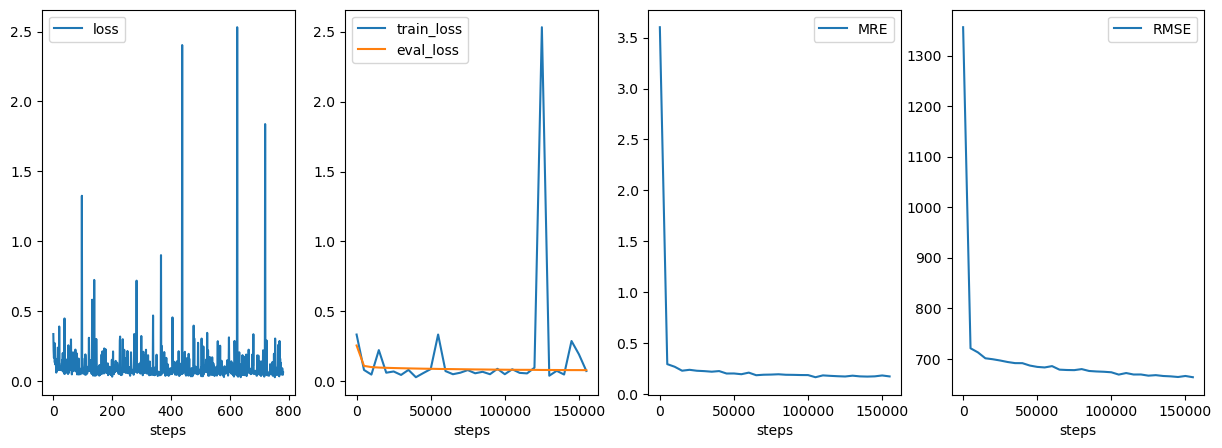

In [18]:
single_train_loop(model_type, conf, preprocessed_train_ds, preprocessed_eval_ds, model, compute_evaluate_metrics, to_device)

In [19]:
from executor import grid_search_loop
reload(executor)
# grid_search_loop(
#     model_type,
#     conf,
#     preprocessed_train_ds,
#     preprocessed_eval_ds,
#     compute_evaluate_metrics,
#     to_device,
#     init_model,
# )

<module 'executor' from '/root/guohao/repos/DLT-perf-model/notebooks/executor.py'>